In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data of Chipotle orders
df = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv', sep='\t')

In [3]:
# Convert prices to float 
df['item_price'] = df['item_price'].str.replace('$','').astype(float)

# Create full order price column and total item quantity column
for idx in df['order_id'].unique():
    df.loc[df['order_id']==idx, 'order_price'] = df.loc[df['order_id']==idx, 'item_price'].sum()
    df.loc[df['order_id']==idx, 'order_quantity'] = df.loc[df['order_id']==idx, 'quantity'].sum()

# Create a dollar per item column
df['dollar_per_item'] = df['order_price']/df['order_quantity']

# Below is code I hijacked from Scott
# Determine which orders contain each category of items
main_items = ['Bowl', 'Burrito', 'Veggie', 'Taco', 'Chips', 'Bottled Water']
orders = {i: df[df['item_name'].str.contains(i)]['order_id'].unique() for i in main_items}

sodas = ['Canned Soft Drink', 'Canned Soda', '6 Pack Soft Drink', 'Izze']
orders['soda'] = df[df['item_name'].isin(sodas)]['order_id'].unique()

# For each order, determine if each is present
df_orders = pd.DataFrame({'order': df['order_id'].unique()})
for i in orders.keys():
    df_orders[i] = df_orders['order'].isin(orders[i])
df_orders.set_index('order', inplace=True)

# Merge the order value info on Scott's df_orders
df_orders = df_orders.merge((df[['order_id', 'order_price', 
                                 'order_quantity', 'dollar_per_item']]
                             .drop_duplicates()
                             .rename(columns={'order_id':'order'})
                             .set_index('order')), 
                            left_index=True, 
                            right_index=True)

# Some descriptives on dollar per item

In [4]:
df.drop_duplicates(subset='order_id')['dollar_per_item'].describe()

count    1834.000000
mean        7.213102
std         2.128147
min         2.790000
25%         5.690000
50%         6.700000
75%         8.750000
max        11.890000
Name: dollar_per_item, dtype: float64

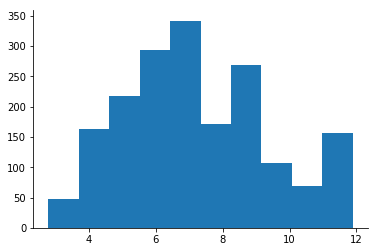

In [5]:
df.drop_duplicates(subset='order_id')['dollar_per_item'].hist()
plt.grid(False)
sns.despine()
plt.show()

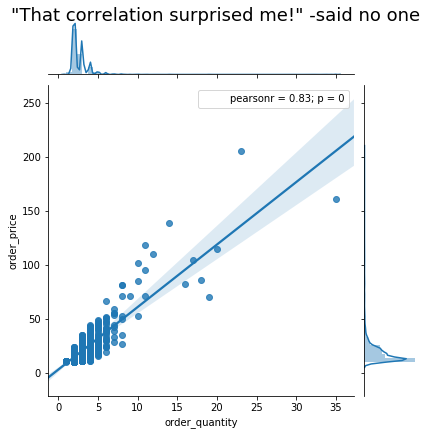

In [6]:
sns.jointplot('order_quantity', 'order_price', df.drop_duplicates(subset='order_id'), kind='reg')
plt.suptitle('''"That correlation surprised me!" -said no one''', fontsize=18, y=0.999)
plt.show()

## Deliciousess for your dollar

In [7]:
df_orders = df_orders.reset_index()

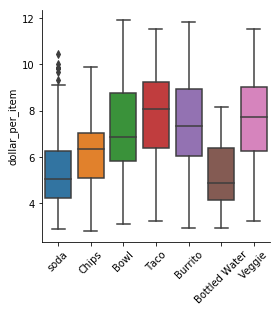

In [8]:
df_tidy = pd.melt(df_orders, id_vars=['order', 'order_price', 'order_quantity', 'dollar_per_item'])
df_tidy = df_tidy.loc[df_tidy['value'] == True].sort_values('order').reset_index(drop=True)

sns.factorplot(x='variable',y='dollar_per_item', data=df_tidy, kind='box')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()

### Dotted lines below represents average item price

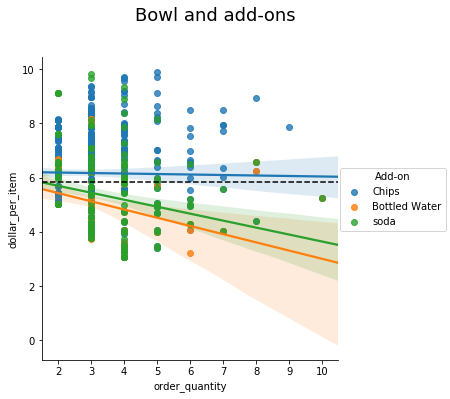

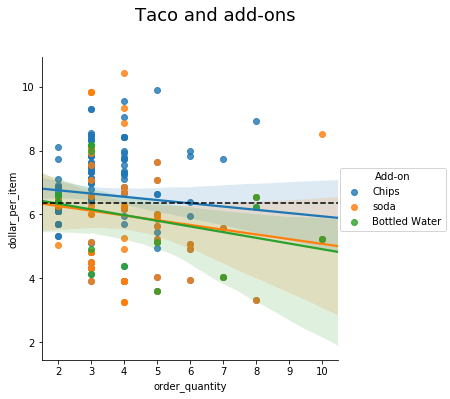

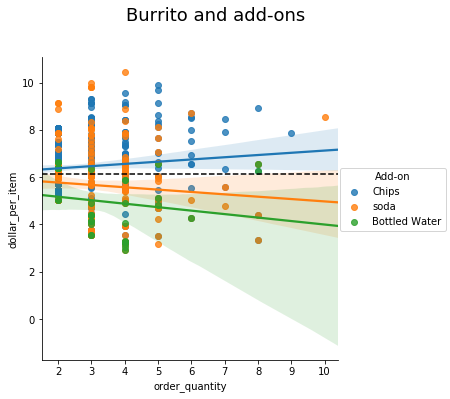

In [9]:
for item in ['Bowl', 'Taco', 'Burrito']:
    df_tidy = pd.melt(df_orders, id_vars=['order', 'order_price', 'order_quantity', 'dollar_per_item', item], var_name='Add-on')
    df_tidy = df_tidy.loc[(df_tidy['value'] == True) & (df_tidy[item] == True)].sort_values('order').reset_index(drop=True)
    df_tidy = df_tidy.loc[df_tidy['order_quantity']<11]
    df_tidy = df_tidy.loc[df_tidy['Add-on'].isin(['soda', 'Chips', 'Bottled Water'])]

    sns.lmplot(x='order_quantity',y='dollar_per_item', data=df_tidy, 
               hue='Add-on')
    plt.axhline(df_tidy.loc[df_tidy[item], 'dollar_per_item'].mean(), color='k', ls='--')
    plt.suptitle(item + ' and add-ons', y=1.1, fontsize=18)
    plt.show()